In [75]:
import matplotlib.pyplot as plt

%matplotlib inline

from collections import Counter
import json
from nltk.tokenize.api import TokenizerI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.api import StemmerI
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from scipy.sparse import dok_matrix
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

spam_dataset = pd.read_csv(
    'spam.csv',
    encoding='ISO-8859-1',
    usecols=[
        0,
        1,
    ],
    names=[
        'spam',
        'message',
    ],
    header=0)

spam_dataset['spam'] = np.where(spam_dataset['spam'].str.contains('spam'), 1, 0)

original_spam_ratio = len(spam_dataset[spam_dataset['spam'] == 1])/len(spam_dataset['spam'])
print('The total ham/spam ratio is {}.'.format(original_spam_ratio))

The total ham/spam ratio is 0.13406317300789664.


In [76]:
X = spam_dataset['message']
y = spam_dataset['spam']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=38,
    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.15,
    random_state=38,
    stratify=y_train_val)

train_spam_ratio = len(y_train[y_train == 1])/len(y_train)
print('The training set ham/spam ratio is {}.'.format(train_spam_ratio))

The training set ham/spam ratio is 0.1341614906832298.


# Visualizing the training set

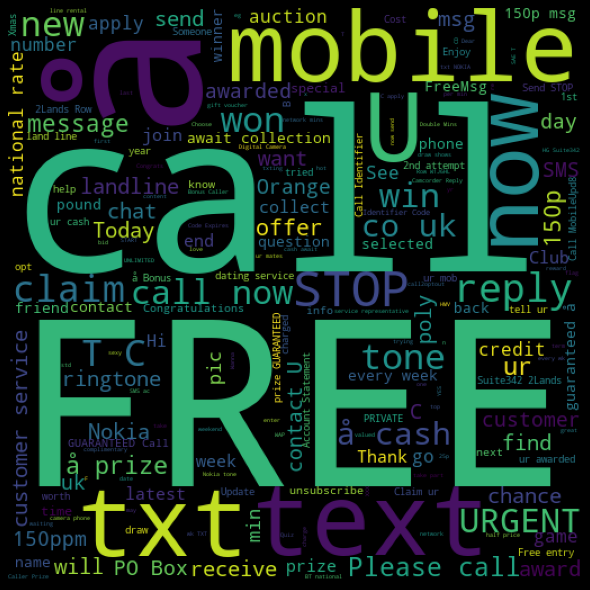

In [77]:
spam_words = ' '.join(list(X_train[y_train == 1]))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

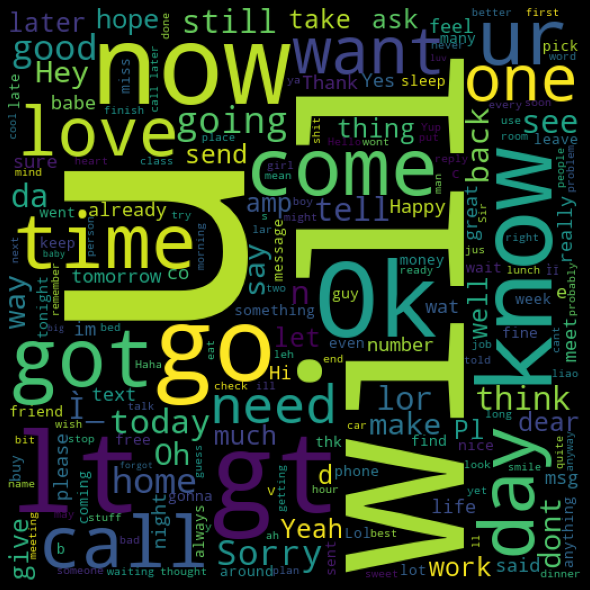

In [78]:
ham_words = ' '.join(list(X_train[y_train == 0]))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Defining a custom vectorizer

In [79]:
class CustomTokenizer(object):
    def __init__(self, tokenizer: TokenizerI, stemmer: StemmerI=None, lower_case: bool=True, exclude_stopwords: bool=True) -> None:
        self.tokenizer = tokenizer
        self.stemmer = stemmer
        self.lower_case = lower_case
        self.exclude_stopwords = exclude_stopwords
    
    def tokenize(self, message: str) -> Counter:
        if self.lower_case:
            message = message.lower()
        
        words = self.tokenizer.tokenize(message)
    
        if self.exclude_stopwords:
            exclude_words = stopwords.words('english')
            words = [word for word in words if word not in exclude_words]
        
        if self.stemmer != None:
            words = [self.stemmer.stem(word) for word in words]
        
        bag = Counter()
        
        for word in words:
            if word not in bag:
                bag[word] = 1
            else:
                bag[word] += 1
        return bag

In [80]:
class CustomVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer: 'CustomTokenizer', num_ham_words: int=np.inf, num_spam_words: int=np.inf):
        super().__init__()
        self.num_ham_words = num_ham_words
        self.num_spam_words = num_spam_words
        self.tokenizer = tokenizer
        self.words = None
        self.ham_words = None
        self.spam_words = None
        
    def fit(self, X, y) -> np.array:
        spam_words = Counter()
        ham_words = Counter()
        
        for index, row in X.iteritems():
            for word in self.tokenizer.tokenize(row):
                if y[index] == 0:
                    if word not in ham_words:
                        ham_words[word] = 1
                    else:
                        ham_words[word] += 1
                elif y[index] == 1:
                    if word not in spam_words:
                        spam_words[word] = 1
                    else:
                        spam_words[word] += 1
                else:
                    raise ValueError('y can only take on 0 (ham) or 1 (spam). Got {}.'.format(y[index]))
        
        ham_word_freqs = sorted(ham_words.items(), key=lambda x: x[1], reverse=True)
        spam_word_freqs = sorted(spam_words.items(), key=lambda x: x[1], reverse=True)
        
        ham_words = [word[0] for word in ham_word_freqs]
        spam_words = [word[0] for word in spam_word_freqs]
        
        if len(ham_words) >= self.num_ham_words:
            self.ham_words = ham_words[:self.num_ham_words]
        else:
            self.ham_words = ham_words
        
        if len(spam_words) >= self.num_spam_words:
            self.spam_words = spam_words[:self.num_spam_words]
        else:
            self.spam_words = spam_words
        
        self.words = self.ham_words + spam_words
        return self
    
    def transform(self, X) -> dok_matrix:
        if self.words == None:
            raise Exception('Fit must be run before transform.')
        
        features = dok_matrix((len(X), len(self.words)), dtype=np.float32)
        for i in range(len(X)):
            message = self.tokenizer.tokenize(X.iloc[i])
            for j in range(len(self.words)):
                if self.words[j] in message:
                    features[i, j] = message[self.words[j]]
        return features.toarray()
    
    def words_to_json(self, filename: str) -> None:
        if self.words == None:
            raise Exception('No words extracted. Run the extract method.')
            
        with open(filename, 'w') as file:
            json.dump(self.words, file, indent=4)

In [81]:
def print_score(model: ClassifierMixin, X, y, num_to_display=20) -> None:
    score = model.score(X, y)
    y_pred = model.predict(X)
    
    print('The accuracy score is approximately {:.4f}.'.format(score))
    print('The precision score is approximately {:.4f}.'.format(precision_score(y, y_pred)))
    print('The recall score is approximately {:.4f}.'.format(recall_score(y, y_pred)))
    print('The f1 score is approximately {:.4f}.'.format(f1_score(y, y_pred)))


# Benchmarking using existing vectorizers

The purpose of this section is to use existing vectorizers to create a benchmark. This is done by scoring them with various hyperparameters on the cross-validation set.

The accuracy score is approximately 0.9845.
The precision score is approximately 0.9565.
The recall score is approximately 0.9263.
The f1 score is approximately 0.9412.


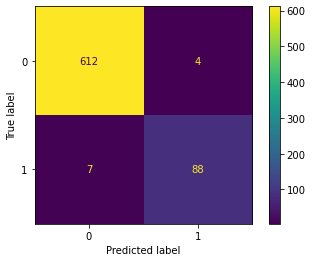

In [82]:
bow_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

bow_pipe.fit(X_train, y_train)

print_score(bow_pipe, X_val, y_val)
plot_confusion_matrix(bow_pipe, X_val, y_val)

The accuracy score is approximately 0.9817.
The precision score is approximately 0.9362.
The recall score is approximately 0.9263.
The f1 score is approximately 0.9312.


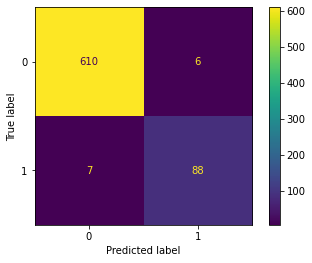

In [83]:
bow2_pipe = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

bow2_pipe.fit(X_train, y_train)

print_score(bow2_pipe, X_val, y_val)
plot_confusion_matrix(bow2_pipe, X_val, y_val)

The accuracy score is approximately 0.9831.
The precision score is approximately 0.9663.
The recall score is approximately 0.9053.
The f1 score is approximately 0.9348.


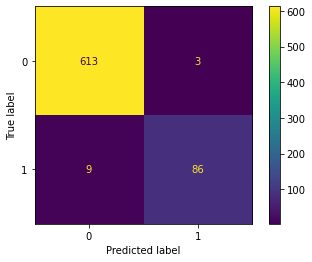

In [84]:
bin_pipe = Pipeline([
    ('vectorizer', CountVectorizer(binary=True)),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

bin_pipe.fit(X_train, y_train)

print_score(bin_pipe, X_val, y_val)
plot_confusion_matrix(bin_pipe, X_val, y_val)

The accuracy score is approximately 0.9789.
The precision score is approximately 1.0000.
The recall score is approximately 0.8421.
The f1 score is approximately 0.9143.


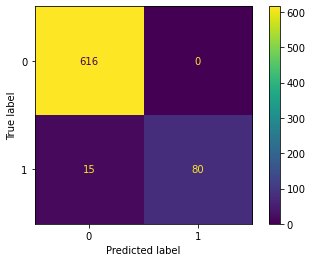

In [85]:
tfidf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

tfidf_pipe.fit(X_train, y_train)

print_score(tfidf_pipe, X_val, y_val)
plot_confusion_matrix(tfidf_pipe, X_val, y_val)

The accuracy score is approximately 0.9634.
The precision score is approximately 1.0000.
The recall score is approximately 0.7263.
The f1 score is approximately 0.8415.


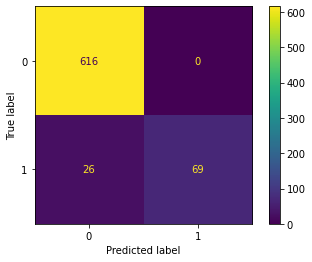

In [86]:
tfidfngram_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

tfidfngram_pipe.fit(X_train, y_train)

print_score(tfidfngram_pipe, X_val, y_val)
plot_confusion_matrix(tfidfngram_pipe, X_val, y_val)

# Tuning the custom vectorizer

The goal of this section is to tune custom vectorizer to perform as well as or better than the benchmarks above on the cross-validaiton set.

The accuracy score is approximately 0.9705.
The precision score is approximately 0.8776.
The recall score is approximately 0.9053.
The f1 score is approximately 0.8912.


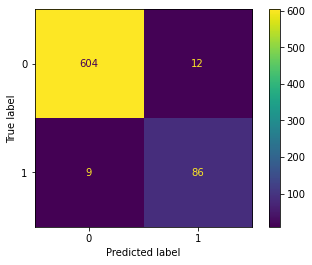

In [87]:
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
custom_tokenizer = CustomTokenizer(tokenizer, stemmer)

custom_pipe = Pipeline([
    ('custom_vectorizer', CustomVectorizer(custom_tokenizer, num_ham_words=100, num_spam_words=100)),
    ('naive_bayes', MultinomialNB(alpha=1.0)),
    ])

custom_pipe.fit(X_train, y_train)

print_score(custom_pipe, X_val, y_val)
plot_confusion_matrix(custom_pipe, X_val, y_val)

# Scoring with the test set

The purpose of this section is to score the custom vectorizer using the test set.